## **AttentiveFP Model, without global features**

In [ ]:
!pip install pandas numpy scikit-learn matplotlib rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 47.5 MB/s eta 0:00:00


In [ ]:
!pip install torch torchvision


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
!pip install rdkit

In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.9 MB/s eta 0:00:00


In [ ]:
!pip install deepchem

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.3 MB/s eta 0:00:00


In [ ]:
!pip install dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 25.7 MB/s eta 0:00:00


In [ ]:
"""
DGL-based AttentiveFP for graph property prediction.
"""
import torch.nn as nn
import torch.nn.functional as F

from deepchem.models.losses import Loss, L2Loss, SparseSoftmaxCrossEntropy
from deepchem.models.torch_models.torch_model import TorchModel


class AttentiveFP(nn.Module):
    """Model for Graph Property Prediction.

    This model proceeds as follows:

    * Combine node features and edge features for initializing node representations,
        which involves a round of message passing
    * Update node representations with multiple rounds of message passing
    * For each graph, compute its representation by combining the representations
        of all nodes in it, which involves a gated recurrent unit (GRU).
    * Perform the final prediction using a linear layer

    Examples
    --------

    >>> import deepchem as dc
    >>> import dgl
    >>> from deepchem.models import AttentiveFP
    >>> smiles = ["C1CCC1", "C1=CC=CN=C1"]
    >>> featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    >>> graphs = featurizer.featurize(smiles)
    >>> print(type(graphs[0]))
    <class 'deepchem.feat.graph_data.GraphData'>
    >>> dgl_graphs = [graphs[i].to_dgl_graph(self_loop=True) for i in range(len(graphs))]
    >>> # Batch two graphs into a graph of two connected components
    >>> batch_dgl_graph = dgl.batch(dgl_graphs)
    >>> model = AttentiveFP(n_tasks=1, mode='regression')
    >>> preds = model(batch_dgl_graph)
    >>> print(type(preds))
    <class 'torch.Tensor'>
    >>> preds.shape == (2, 1)
    True

    References
    ----------
    .. [1] Zhaoping Xiong, Dingyan Wang, Xiaohong Liu, Feisheng Zhong, Xiaozhe Wan, Xutong Li,
        Zhaojun Li, Xiaomin Luo, Kaixian Chen, Hualiang Jiang, and Mingyue Zheng. "Pushing
        the Boundaries of Molecular Representation for Drug Discovery with the Graph Attention
        Mechanism." Journal of Medicinal Chemistry. 2020, 63, 16, 8749–8760.

    Notes
    -----
    This class requires DGL (https://github.com/dmlc/dgl) and DGL-LifeSci
    (https://github.com/awslabs/dgl-lifesci) to be installed.
    """

    def __init__(self,
                 n_tasks: int,
                 num_layers: int = 2,
                 num_timesteps: int = 2,
                 graph_feat_size: int = 200,
                 dropout: float = 0.,
                 mode: str = 'regression',
                 number_atom_features: int = 30,
                 number_bond_features: int = 11,
                 n_classes: int = 2,
                 nfeat_name: str = 'x',
                 efeat_name: str = 'edge_attr'):
        """
        Parameters
        ----------
        n_tasks: int
            Number of tasks.
        num_layers: int
            Number of graph neural network layers, i.e. number of rounds of message passing.
            Default to 2.
        num_timesteps: int
            Number of time steps for updating graph representations with a GRU. Default to 2.
        graph_feat_size: int
            Size for graph representations. Default to 200.
        dropout: float
            Dropout probability. Default to 0.
        mode: str
            The model type, 'classification' or 'regression'. Default to 'regression'.
        number_atom_features: int
            The length of the initial atom feature vectors. Default to 30.
        number_bond_features: int
            The length of the initial bond feature vectors. Default to 11.
        n_classes: int
            The number of classes to predict per task
            (only used when ``mode`` is 'classification'). Default to 2.
        nfeat_name: str
            For an input graph ``g``, the model assumes that it stores node features in
            ``g.ndata[nfeat_name]`` and will retrieve input node features from that.
            Default to 'x'.
        efeat_name: str
            For an input graph ``g``, the model assumes that it stores edge features in
            ``g.edata[efeat_name]`` and will retrieve input edge features from that.
            Default to 'edge_attr'.
        """
        try:
            import dgl  # noqa: F401
        except:
            raise ImportError('This class requires dgl.')
        try:
            import dgllife  # noqa: F401
        except:
            raise ImportError('This class requires dgllife.')

        if mode not in ['classification', 'regression']:
            raise ValueError(
                "mode must be either 'classification' or 'regression'")

        super(AttentiveFP, self).__init__()

        self.n_tasks = n_tasks
        self.mode = mode
        self.n_classes = n_classes
        self.nfeat_name = nfeat_name
        self.efeat_name = efeat_name
        if mode == 'classification':
            out_size = n_tasks * n_classes
        else:
            out_size = n_tasks

        from dgllife.model import AttentiveFPPredictor as DGLAttentiveFPPredictor

        self.model = DGLAttentiveFPPredictor(
            node_feat_size=number_atom_features,
            edge_feat_size=number_bond_features,
            num_layers=num_layers,
            num_timesteps=num_timesteps,
            graph_feat_size=graph_feat_size,
            n_tasks=out_size,
            dropout=dropout)

    def forward(self, g):
        """Predict graph labels

        Parameters
        ----------
        g: DGLGraph
            A DGLGraph for a batch of graphs. It stores the node features in
            ``dgl_graph.ndata[self.nfeat_name]`` and edge features in
            ``dgl_graph.edata[self.efeat_name]``.

        Returns
        -------
        torch.Tensor
            The model output.

        * When self.mode = 'regression',
            its shape will be ``(dgl_graph.batch_size, self.n_tasks)``.
        * When self.mode = 'classification', the output consists of probabilities
            for classes. Its shape will be
            ``(dgl_graph.batch_size, self.n_tasks, self.n_classes)`` if self.n_tasks > 1;
            its shape will be ``(dgl_graph.batch_size, self.n_classes)`` if self.n_tasks is 1.
        torch.Tensor, optional
            This is only returned when self.mode = 'classification', the output consists of the
            logits for classes before softmax.
        """
        node_feats = g.ndata[self.nfeat_name]
        edge_feats = g.edata[self.efeat_name]
        out = self.model(g, node_feats, edge_feats)

        if self.mode == 'classification':
            if self.n_tasks == 1:
                logits = out.view(-1, self.n_classes)
                softmax_dim = 1
            else:
                logits = out.view(-1, self.n_tasks, self.n_classes)
                softmax_dim = 2
            proba = F.softmax(logits, dim=softmax_dim)
            return proba, logits
        else:
            return out


class AttentiveFPModel(TorchModel):
    """Model for Graph Property Prediction.

    This model proceeds as follows:

    * Combine node features and edge features for initializing node representations,
        which involves a round of message passing
    * Update node representations with multiple rounds of message passing
    * For each graph, compute its representation by combining the representations
        of all nodes in it, which involves a gated recurrent unit (GRU).
    * Perform the final prediction using a linear layer

    Examples
    --------
    >>> import deepchem as dc
    >>> from deepchem.models import AttentiveFPModel
    >>> # preparing dataset
    >>> smiles = ["C1CCC1", "C1=CC=CN=C1"]
    >>> labels = [0., 1.]
    >>> featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
    >>> X = featurizer.featurize(smiles)
    >>> dataset = dc.data.NumpyDataset(X=X, y=labels)
    >>> # training model
    >>> model = AttentiveFPModel(mode='classification', n_tasks=1,
    ...    batch_size=16, learning_rate=0.001)
    >>> loss = model.fit(dataset, nb_epoch=5)

    References
    ----------
    .. [1] Zhaoping Xiong, Dingyan Wang, Xiaohong Liu, Feisheng Zhong, Xiaozhe Wan, Xutong Li,
        Zhaojun Li, Xiaomin Luo, Kaixian Chen, Hualiang Jiang, and Mingyue Zheng. "Pushing
        the Boundaries of Molecular Representation for Drug Discovery with the Graph
        Attention Mechanism." Journal of Medicinal Chemistry. 2020, 63, 16, 8749–8760.

    Notes
    -----
    This class requires DGL (https://github.com/dmlc/dgl) and DGL-LifeSci
    (https://github.com/awslabs/dgl-lifesci) to be installed.
    """

    def __init__(self,
                 n_tasks: int,
                 num_layers: int = 2,
                 num_timesteps: int = 2,
                 graph_feat_size: int = 200,
                 dropout: float = 0.,
                 mode: str = 'regression',
                 number_atom_features: int = 30,
                 number_bond_features: int = 11,
                 n_classes: int = 2,
                 self_loop: bool = True,
                 **kwargs):
        """
        Parameters
        ----------
        n_tasks: int
            Number of tasks.
        num_layers: int
            Number of graph neural network layers, i.e. number of rounds of message passing.
            Default to 2.
        num_timesteps: int
            Number of time steps for updating graph representations with a GRU. Default to 2.
        graph_feat_size: int
            Size for graph representations. Default to 200.
        dropout: float
            Dropout probability. Default to 0.
        mode: str
            The model type, 'classification' or 'regression'. Default to 'regression'.
        number_atom_features: int
            The length of the initial atom feature vectors. Default to 30.
        number_bond_features: int
            The length of the initial bond feature vectors. Default to 11.
        n_classes: int
            The number of classes to predict per task
            (only used when ``mode`` is 'classification'). Default to 2.
        self_loop: bool
            Whether to add self loops for the nodes, i.e. edges from nodes to themselves.
            When input graphs have isolated nodes, self loops allow preserving the original feature
            of them in message passing. Default to True.
        kwargs
            This can include any keyword argument of TorchModel.
        """
        model = AttentiveFP(n_tasks=n_tasks,
                            num_layers=num_layers,
                            num_timesteps=num_timesteps,
                            graph_feat_size=graph_feat_size,
                            dropout=dropout,
                            mode=mode,
                            number_atom_features=number_atom_features,
                            number_bond_features=number_bond_features,
                            n_classes=n_classes)
        if mode == 'regression':
            loss: Loss = L2Loss()
            output_types = ['prediction']
        else:
            loss = SparseSoftmaxCrossEntropy()
            output_types = ['prediction', 'loss']
        super(AttentiveFPModel, self).__init__(model,
                                               loss=loss,
                                               output_types=output_types,
                                               **kwargs)

        self._self_loop = self_loop

    def _prepare_batch(self, batch):
        """Create batch data for AttentiveFP.

        Parameters
        ----------
        batch: tuple
            The tuple is ``(inputs, labels, weights)``.

        Returns
        -------
        inputs: DGLGraph
            DGLGraph for a batch of graphs.
        labels: list of torch.Tensor or None
            The graph labels.
        weights: list of torch.Tensor or None
            The weights for each sample or sample/task pair converted to torch.Tensor.
        """
        try:
            import dgl
        except:
            raise ImportError('This class requires dgl.')

        inputs, labels, weights = batch
        dgl_graphs = [
            graph.to_dgl_graph(self_loop=self._self_loop) for graph in inputs[0]
        ]
        inputs = dgl.batch(dgl_graphs).to(self.device)
        _, labels, weights = super(AttentiveFPModel, self)._prepare_batch(
            ([], labels, weights))
        return inputs, labels, weights

Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead
DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


In [ ]:
import pandas as pd
#read in curated dataset
smilesdf = pd.read_csv('filtered_smiles.csv')
print(smilesdf.head())

    ID                                               Name  \
0  A-3         N,N,N-trimethyloctadecan-1-aminium bromide   
1  A-4                           Benzo[cd]indol-2(1H)-one   
2  A-5                               4-chlorobenzaldehyde   
3  A-8  zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...   
4  A-9  4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...   

                                               InChI  \
0  InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...   
1  InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...   
2        InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H   
3  InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...   
4  InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...   

                      InChIKey  \
0  SZEMGTQCPRNXEG-UHFFFAOYSA-M   
1  GPYLCFQEKPUWLD-UHFFFAOYSA-N   
2  AVPYQKSLYISFPO-UHFFFAOYSA-N   
3  XTUPUYCJWKHGSW-UHFFFAOYSA-L   
4  FAUAZXVRLVIARB-UHFFFAOYSA-N   

                                              SMILES  Solubility   SD  \
0                [

In [ ]:
import deepchem as dc

#initialize featurizer
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)

#featurize smiles for curated dataset
graphs = featurizer.featurize(smilesdf['SMILES'].tolist())

[20:20:57] WARNING: not removing hydrogen atom without neighbors
[20:20:57] WARNING: not removing hydrogen atom without neighbors
[20:20:57] WARNING: not removing hydrogen atom without neighbors
[20:20:58] WARNING: not removing hydrogen atom without neighbors
[20:20:59] WARNING: not removing hydrogen atom without neighbors
[20:21:07] WARNING: not removing hydrogen atom without neighbors
[20:21:07] WARNING: not removing hydrogen atom without neighbors
[20:21:07] WARNING: not removing hydrogen atom without neighbors
[20:21:07] WARNING: not removing hydrogen atom without neighbors
[20:21:07] WARNING: not removing hydrogen atom without neighbors
[20:21:08] WARNING: not removing hydrogen atom without neighbors
[20:21:08] WARNING: not removing hydrogen atom without neighbors
[20:21:09] WARNING: not removing hydrogen atom without neighbors
[20:21:09] WARNING: not removing hydrogen atom without neighbors
[20:21:09] WARNING: not removing hydrogen atom without neighbors
[20:21:09] WARNING: not r

In [ ]:
import dgl

#convert deepchem to DGL graph using to_dgl_graph function
dgl_graphs = [graph.to_dgl_graph() for graph in graphs if hasattr(graph, 'to_dgl_graph')]

print(f"Converted {len(dgl_graphs)} graphs to DGL format.")


Converted 9623 graphs to DGL format.


In [ ]:
import torch
#find maximum and minimum solubility values
max_solubility = smilesdf['Solubility'].max()
min_solubility = smilesdf['Solubility'].min()

print(f"Maximum solubility: {max_solubility}")
print(f"Minimum solubility: {min_solubility}")

#featurize labels from solubility column
solubility_labels = smilesdf['Solubility'].values
labels_tensor = torch.tensor(solubility_labels, dtype=torch.float)
print(labels_tensor)

Maximum solubility: 2.13768162
Minimum solubility: -13.1719
tensor([-3.6161, -3.2548, -2.1771,  ..., -2.1900, -3.9800, -4.7800])


In [ ]:
#class to take individual graphs as data

from torch.utils.data import Dataset, DataLoader

class GraphDataset(Dataset):
    def __init__(self, graphs, labels):
        super(GraphDataset, self).__init__()
        self.graphs = graphs
        self.labels = labels

    def __len__(self):
        return len(self.graphs)

    def __getitem__(self, idx):
        return self.graphs[idx], self.labels[idx]

#initialize dataset with list of graphs and list of labels as tensor
dataset = GraphDataset(dgl_graphs, labels_tensor)



In [ ]:
import dgl
import torch

def collate(samples):
    # `samples` is a list of pairs (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)  # Batch all the graphs into one large graph
    return batched_graph, torch.tensor(labels)



In [ ]:
!pip install dgllife


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 5.7 MB/s eta 0:00:00


In [ ]:
#model initialization
import dgllife

AttentiveFPmodel = AttentiveFP(
    n_tasks=1,
    num_layers=3,
    num_timesteps=2,
    graph_feat_size=200,
    dropout=0.2,
    mode='regression',
    number_atom_features=30,
    number_bond_features=11
)

In [ ]:
#split datasets for training and test
from sklearn.model_selection import train_test_split

graphs_and_labels = list(zip(dgl_graphs, solubility_labels))
Attn_train_data, Attn_test_data = train_test_split(graphs_and_labels, test_size=0.30, random_state=42)
#extract graphs and labels from training data
train_graphs, train_labels = zip(*Attn_train_data)
train_labels = torch.tensor(train_labels, dtype=torch.float32)  # Convert labels to tensor

#extract graphs and labels from testing data
test_graphs, test_labels = zip(*Attn_test_data)
test_labels = torch.tensor(test_labels, dtype=torch.float32)  # Convert labels to tensor


In [ ]:
#dataloader initialization for training and test sets
from torch.utils.data import DataLoader

Attn_train_dataset = GraphDataset(list(train_graphs), train_labels)
Attn_train_loader = DataLoader(Attn_train_dataset, batch_size=32, shuffle=True, collate_fn=collate)

Attn_test_dataset = GraphDataset(list(test_graphs), test_labels)
Attn_test_loader = DataLoader(Attn_test_dataset, batch_size=32, shuffle=False, collate_fn=collate)


In [ ]:
#optimizer initialization and train model
import torch.optim as optim
import torch
from torch.optim.lr_scheduler import ExponentialLR

criterion = torch.nn.MSELoss()
optimizer = optim.Adam(AttentiveFPmodel.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.95)

AttentiveFPmodel.train()
epochs = 150

for epoch in range(epochs):
    total_loss = 0
    for batched_graph, targets in Attn_train_loader:
        optimizer.zero_grad()  # Clear gradients
        predictions = AttentiveFPmodel(batched_graph)  # Forward pass
        predictions = predictions.view(-1)
        targets = targets.float()  # Ensure targets are floats (if they're not already)
        loss = criterion(predictions, targets)  # Calculate loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        total_loss += loss.item()  # Accumulate loss for the epoch
    scheduler.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(Attn_train_loader):.4f}')



Epoch 1/150, Loss: 0.5981
Epoch 2/150, Loss: 0.5616
Epoch 3/150, Loss: 0.5447
Epoch 4/150, Loss: 0.5213
Epoch 5/150, Loss: 0.4793
Epoch 6/150, Loss: 0.4491
Epoch 7/150, Loss: 0.4508
Epoch 8/150, Loss: 0.4245
Epoch 9/150, Loss: 0.4036
Epoch 10/150, Loss: 0.3855
Epoch 11/150, Loss: 0.3705
Epoch 12/150, Loss: 0.3514
Epoch 13/150, Loss: 0.3364
Epoch 14/150, Loss: 0.3179
Epoch 15/150, Loss: 0.3003
Epoch 16/150, Loss: 0.2886
Epoch 17/150, Loss: 0.2820
Epoch 18/150, Loss: 0.2628
Epoch 19/150, Loss: 0.2641
Epoch 20/150, Loss: 0.2508
Epoch 21/150, Loss: 0.2452
Epoch 22/150, Loss: 0.2403
Epoch 23/150, Loss: 0.2236
Epoch 24/150, Loss: 0.2212
Epoch 25/150, Loss: 0.2062
Epoch 26/150, Loss: 0.2090
Epoch 27/150, Loss: 0.2000
Epoch 28/150, Loss: 0.1991
Epoch 29/150, Loss: 0.1907
Epoch 30/150, Loss: 0.1877
Epoch 31/150, Loss: 0.1857
Epoch 32/150, Loss: 0.1778
Epoch 33/150, Loss: 0.1769
Epoch 34/150, Loss: 0.1676
Epoch 35/150, Loss: 0.1615
Epoch 36/150, Loss: 0.1597
Epoch 37/150, Loss: 0.1597
Epoch 38/1

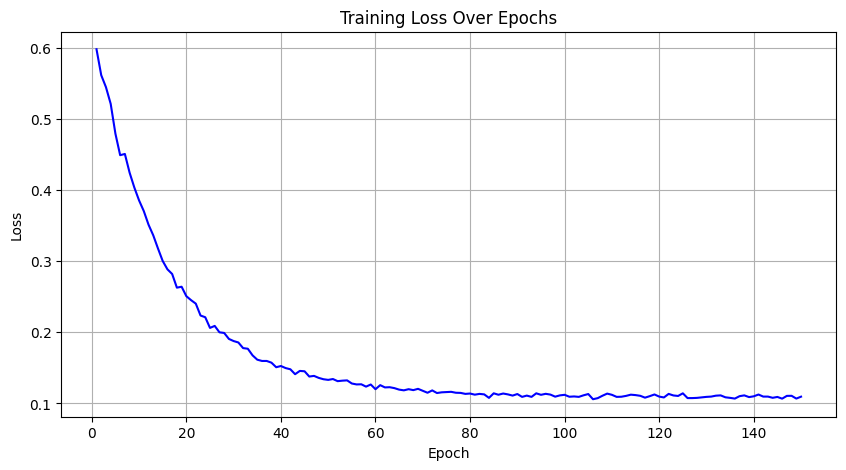

In [ ]:

# Load the data from the CSV file
df = pd.read_csv('Epoch_Losses.csv')

# Plot the training loss over the epochs
plt.figure(figsize=(10, 5))
plt.plot(df['Epoch'], df['Loss'],color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
#evaluate attentiveFPmodel
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
def evaluate_model(model, test_loader, criterion):
    model.eval()
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for batched_graph, labels in test_loader:
            outputs = model(batched_graph)
            outputs = outputs.view(-1)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Collect predictions and actual labels
            predictions.extend(outputs.tolist())
            actuals.extend(labels.tolist())

    test_loss = total_loss / len(test_loader)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Mean Absolute Error: {mae:.4f}')
    print(f'Mean Squared Error: {mse:.4f}')
    print(f'Root Mean Squared Error: {rmse:.4f}')

    return predictions, actuals

# Call the function and store predictions and actuals
predictions, actuals = evaluate_model(AttentiveFPmodel, Attn_test_loader, torch.nn.MSELoss())



Test Loss: 0.8986
Mean Absolute Error: 0.6150
Mean Squared Error: 0.8992
Root Mean Squared Error: 0.9483


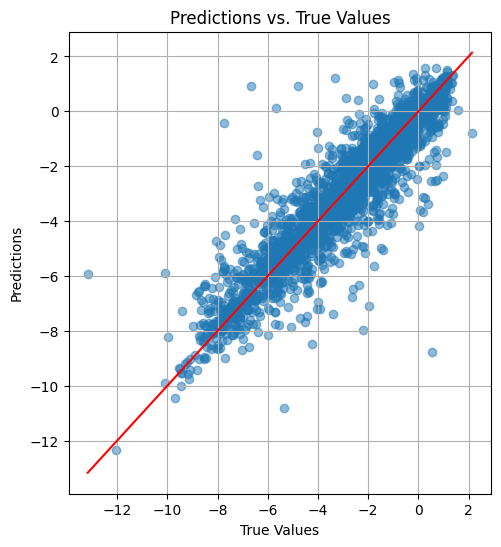

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(actuals, predictions, alpha=0.5)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r')  # A line y=x for reference
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs. True Values')
plt.grid(True)



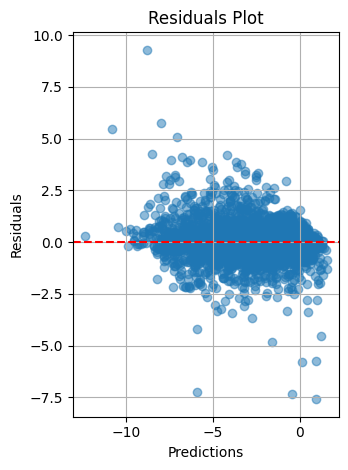

In [ ]:
residuals = [actual - pred for actual, pred in zip(actuals, predictions)]

plt.subplot(1, 2, 2)
plt.scatter(predictions, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.grid(True)

plt.tight_layout()
plt.show()


## **AttentiveFP with molecular descriptors**

In [ ]:
descriptors = smilesdf[['TPSA', 'MolLogP', 'NumHAcceptors', 'NumHDonors', 'RingCount']].values
descriptors_tensor = torch.tensor(descriptors, dtype=torch.float32)  # Convert to a PyTorch tensor
labels = smilesdf['Solubility'].values
labels_tensor = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

In [ ]:
from torch.utils.data import Dataset, DataLoader

class GraphDataset(Dataset):
    def __init__(self, graphs, descriptors, labels):
        self.graphs = graphs
        self.descriptors = descriptors
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.graphs[idx], self.descriptors[idx], self.labels[idx]

# Create dataset instances
train_dataset = GraphDataset(train_dgl_graphs, train_descriptors, train_labels)
test_dataset = GraphDataset(test_dgl_graphs, test_descriptors, test_labels)


In [ ]:
def collate(samples):
    graphs, descriptors, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    batched_descriptors = torch.stack(descriptors)
    batched_labels = torch.stack(labels)
    return batched_graph, batched_descriptors, batched_labels

In [ ]:
train_dgl_graphs, test_dgl_graphs, train_descriptors, test_descriptors, train_labels, test_labels = train_test_split(
    dgl_graphs, descriptors_tensor, labels_tensor, test_size=0.30, random_state=42
)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate)



In [ ]:
class ExtendedAttentiveFP(nn.Module):
    def __init__(self, graph_model, descriptor_dim, output_dim):
        super(ExtendedAttentiveFP, self).__init__()
        self.graph_model = graph_model
        self.fc1 = nn.Linear(descriptor_dim, 128)
        self.fc2 = nn.Linear(128 + output_dim, output_dim)

    def forward(self, graph_data, descriptors):
        graph_out = self.graph_model(graph_data)
        desc_out = F.relu(self.fc1(descriptors))
        combined = torch.cat((graph_out, desc_out), dim=1)
        return self.fc2(combined)


model = ExtendedAttentiveFP(AttentiveFPmodel, descriptor_dim=5, output_dim=1)


In [ ]:
model = ExtendedAttentiveFP(AttentiveFPmodel, descriptor_dim=5, output_dim=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

epochs = 150
epoch_losses = []

for epoch in range(epochs):
    model.train()  # Set model to training mode
    total_loss = 0

    for graphs, descriptors, labels in train_loader:
        optimizer.zero_grad()  # Clear previous gradients
        outputs = model(graphs, descriptors)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backpropagate the error
        optimizer.step()  # Update weights
        total_loss += loss.item()  # Accumulate the loss

    # Adjust learning rate according to the scheduler
    scheduler.step()

    # Calculate and log the average loss for this epoch
    average_loss = total_loss / len(train_loader)
    epoch_losses.append(average_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {average_loss:.4f}')


Epoch 1/150, Loss: 2.3170
Epoch 2/150, Loss: 1.0104
Epoch 3/150, Loss: 0.6928
Epoch 4/150, Loss: 0.5368
Epoch 5/150, Loss: 0.4942
Epoch 6/150, Loss: 0.4102
Epoch 7/150, Loss: 0.4004
Epoch 8/150, Loss: 0.3296
Epoch 9/150, Loss: 0.3040
Epoch 10/150, Loss: 0.2898
Epoch 11/150, Loss: 0.2713
Epoch 12/150, Loss: 0.2421
Epoch 13/150, Loss: 0.2294
Epoch 14/150, Loss: 0.2136
Epoch 15/150, Loss: 0.1943
Epoch 16/150, Loss: 0.2007
Epoch 17/150, Loss: 0.1866
Epoch 18/150, Loss: 0.1856
Epoch 19/150, Loss: 0.1839
Epoch 20/150, Loss: 0.1789
Epoch 21/150, Loss: 0.1626
Epoch 22/150, Loss: 0.1553
Epoch 23/150, Loss: 0.1568
Epoch 24/150, Loss: 0.1515
Epoch 25/150, Loss: 0.1450
Epoch 26/150, Loss: 0.1445
Epoch 27/150, Loss: 0.1426
Epoch 28/150, Loss: 0.1366
Epoch 29/150, Loss: 0.1313
Epoch 30/150, Loss: 0.1282
Epoch 31/150, Loss: 0.1378
Epoch 32/150, Loss: 0.1251
Epoch 33/150, Loss: 0.1181
Epoch 34/150, Loss: 0.1200
Epoch 35/150, Loss: 0.1142
Epoch 36/150, Loss: 0.1154
Epoch 37/150, Loss: 0.1104
Epoch 38/1

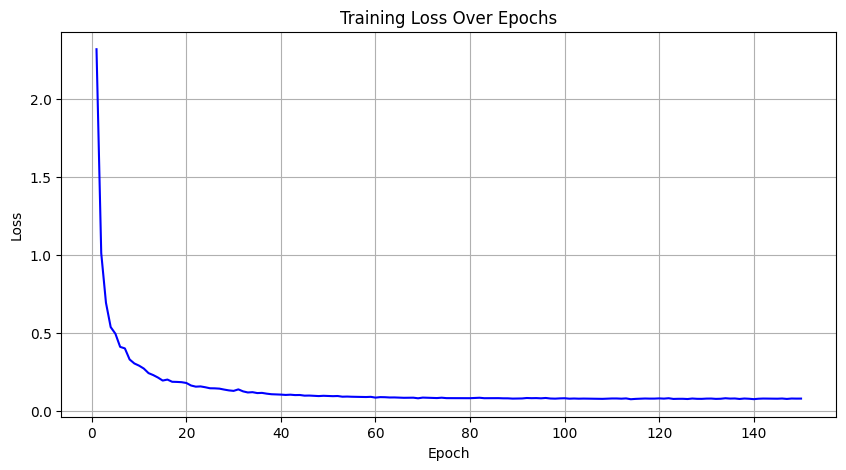

In [ ]:
import matplotlib.pyplot as plt

# Plotting the training loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs+1), epoch_losses, color='blue')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [ ]:
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(model, loader, criterion):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0
    predictions = []
    actuals = []

    with torch.no_grad():
        for graphs, descriptors, labels in loader:
            outputs = model(graphs, descriptors)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Store predictions and actual labels for calculating MAE, MSE, RMSE
            predictions.extend(outputs.flatten().tolist())
            actuals.extend(labels.flatten().tolist())

    test_loss = total_loss / len(loader)
    mae = mean_absolute_error(actuals, predictions)
    mse = mean_squared_error(actuals, predictions)
    rmse = np.sqrt(mse)

    return test_loss, mae, mse, rmse

# Assuming 'test_loader' and 'criterion' are already defined
test_loss, mae, mse, rmse = evaluate_model(model, test_loader, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")


Test Loss: 1.0058
MAE: 0.6305
MSE: 1.0058
RMSE: 1.0029


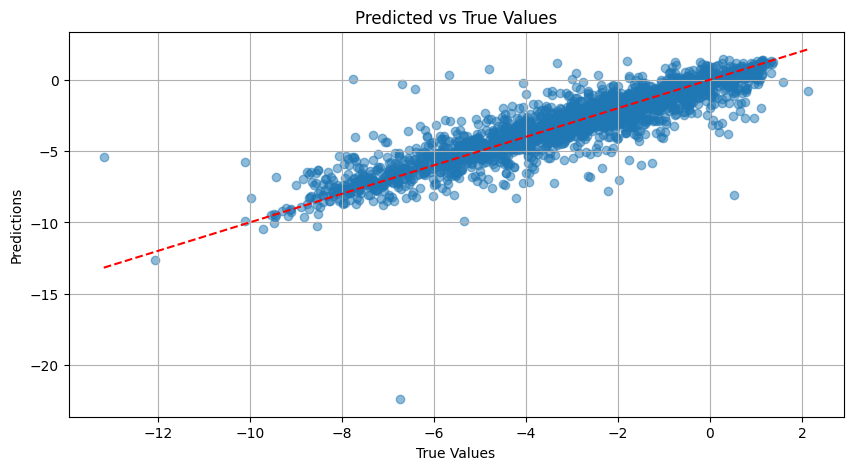

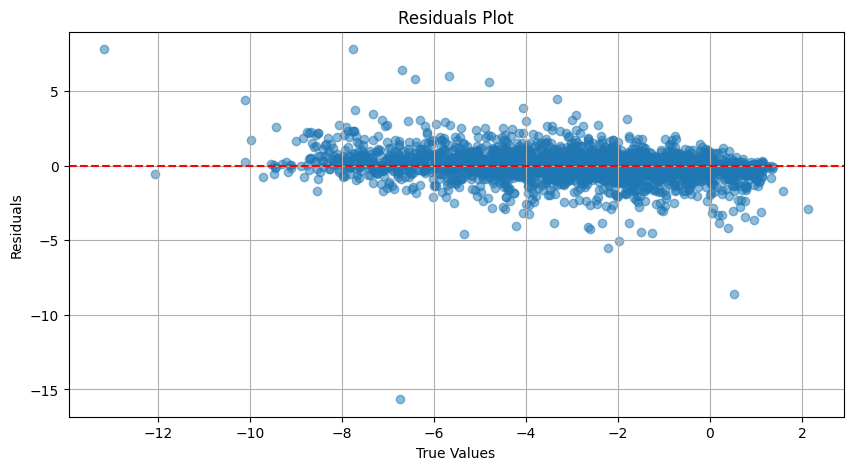

In [ ]:
# Re-run the evaluation to collect actuals and predictions for plotting
model.eval()
all_predictions = []
all_actuals = []
with torch.no_grad():
    for graphs, descriptors, labels in test_loader:
        outputs = model(graphs, descriptors)
        all_predictions.extend(outputs.view(-1).tolist())
        all_actuals.extend(labels.view(-1).tolist())

import matplotlib.pyplot as plt

# Plotting Predicted vs True values
plt.figure(figsize=(10, 5))
plt.scatter(all_actuals, all_predictions, alpha=0.5)
plt.plot([min(all_actuals), max(all_actuals)], [min(all_actuals), max(all_actuals)], 'r--')  # Ideal line
plt.title('Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.grid(True)
plt.show()

# Plotting Residuals
residuals = [pred - act for pred, act in zip(all_predictions, all_actuals)]
plt.figure(figsize=(10, 5))
plt.scatter(all_actuals, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()


## **GCN Implementation**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import rdkit
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.rdmolops import GetAdjacencyMatrix



from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

import torch
from torch_geometric.data import Data

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, TopKPooling
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.nn import BatchNorm

from torch_geometric.loader import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau


In [ ]:
df = pd.read_csv('curated-solubility-dataset.csv')
df.head()

,ID,Name,InChI,InChIKey,SMILES,Solubility,SD,Ocurrences,Group,MolWt,...,NumRotatableBonds,NumValenceElectrons,NumAromaticRings,NumSaturatedRings,NumAliphaticRings,RingCount,TPSA,LabuteASA,BalabanJ,BertzCT
0,A-3,"N,N,N-trimethyloctadecan-1-aminium bromide",InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...,SZEMGTQCPRNXEG-UHFFFAOYSA-M,[Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C,-3.616127,0.0,1,G1,392.510,...,17.0,142.0,0.0,0.0,0.0,0.0,0.00,158.520601,0.000000e+00,210.377334
1,A-4,Benzo[cd]indol-2(1H)-one,InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...,GPYLCFQEKPUWLD-UHFFFAOYSA-N,O=C1Nc2cccc3cccc1c23,-3.254767,0.0,1,G1,169.183,...,0.0,62.0,2.0,0.0,1.0,3.0,29.10,75.183563,2.582996e+00,511.229248
2,A-5,4-chlorobenzaldehyde,InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H,AVPYQKSLYISFPO-UHFFFAOYSA-N,Clc1ccc(C=O)cc1,-2.177078,0.0,1,G1,140.569,...,1.0,46.0,1.0,0.0,0.0,1.0,17.07,58.261134,3.009782e+00,202.661065
3,A-8,"zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...",InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...,XTUPUYCJWKHGSW-UHFFFAOYSA-L,[Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...,-3.924409,0.0,1,G1,756.226,...,10.0,264.0,6.0,0.0,0.0,6.0,120.72,323.755434,2.322963e-07,1964.648666
4,A-9,4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...,InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...,FAUAZXVRLVIARB-UHFFFAOYSA-N,C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...,-4.662065,0.0,1,G1,422.525,...,12.0,164.0,2.0,4.0,4.0,6.0,56.60,183.183268,1.084427e+00,769.899934


In [ ]:
def encoding(x, list_atoms):
    if x not in list_atoms:
        x = list_atoms[-1]

    enc = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, list_atoms))]

    return enc

In [ ]:
def get_atom_features(atom, use_chirality = True, hydrogens_implicit = True):

    # define list of permitted atoms
    permitted_list_of_atoms =  ['C','N','O','S','F','Si','P','Cl','Br','Mg','Na','Ca','Fe','As','Al','I', 'B','V','K','Tl','Yb','Sb','Sn','Ag','Pd','Co','Se','Ti','Zn', 'Li','Ge','Cu','Au','Ni','Cd','In','Mn','Zr','Cr','Pt','Hg','Pb','Unknown']

    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms

    # compute atom features
    atom_type_enc = encoding(str(atom.GetSymbol()), permitted_list_of_atoms)

    n_heavy_neighbors_enc = encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])

    formal_charge_enc = encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])

    hybridisation_type_enc = encoding(str(atom.GetHybridization()), ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])

    is_in_a_ring_enc = [int(atom.IsInRing())]

    is_aromatic_enc = [int(atom.GetIsAromatic())]

    atomic_mass_scaled = [float((atom.GetMass() - 10.812)/116.092)]

    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5)/0.6)]

    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64)/0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled

    if use_chirality == True:
        chirality_type_enc = encoding(str(atom.GetChiralTag()), ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW", "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc

    if hydrogens_implicit == True:
        n_hydrogens_enc = encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)

In [ ]:
def get_bond_features(bond, use_stereochemistry = True):
    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE, Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = encoding(bond.GetBondType(), permitted_list_of_bond_types)

    bond_is_conj_enc = [int(bond.GetIsConjugated())]

    bond_is_in_ring_enc = [int(bond.IsInRing())]

    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc

    if use_stereochemistry == True:
        stereo_type_enc = encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)

In [ ]:
def smiles_to_pyg_graph(x_smiles, y):
    data_list = []

    for (smiles, y_val) in zip(x_smiles, y):

        # convert SMILES to RDKit mol object
        mol = Chem.MolFromSmiles(smiles)

        # get feature dimensions
        n_nodes = mol.GetNumAtoms()
        n_edges = 2*mol.GetNumBonds()
        unrelated_smiles = "O=O"
        unrelated_mol = Chem.MolFromSmiles(unrelated_smiles)
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0,1)))

        # construct node feature matrix X of shape (n_nodes, n_node_features)
        X = np.zeros((n_nodes, n_node_features))

        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)

        X = torch.tensor(X, dtype = torch.float)

        # construct edge index array E of shape (2, n_edges)
        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        torch_rows = torch.from_numpy(rows.astype(np.int64)).to(torch.long)
        torch_cols = torch.from_numpy(cols.astype(np.int64)).to(torch.long)
        E = torch.stack([torch_rows, torch_cols], dim = 0)

        # construct edge feature array EF of shape (n_edges, n_edge_features)
        EF = np.zeros((n_edges, n_edge_features))

        for (k, (i,j)) in enumerate(zip(rows, cols)):

            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i),int(j)))

        EF = torch.tensor(EF, dtype = torch.float)

        # construct label tensor
        y_tensor = torch.tensor(np.array([y_val]), dtype = torch.float)

        # construct Pytorch Geometric data object and append to data list
        data_list.append(Data(x = X, edge_index = E, edge_attr = EF, y = y_tensor))

    return data_list

In [ ]:
smiles_data = df[['SMILES', 'Solubility']]

In [ ]:
# Correct DataFrame reference
x_smiles = smiles_data['SMILES'].tolist()

sanitized_smiles = []
for smiles in x_smiles:
    try:
        # Convert SMILES to a molecule object without automatically applying sanitization
        mol = Chem.MolFromSmiles(smiles, sanitize=False)
        if mol:
            # Explicitly apply sanitization
            Chem.SanitizeMol(mol)
            # Convert the sanitized molecule back to a SMILES string
            sanitized_smiles.append(Chem.MolToSmiles(mol))
        else:
            print("Skipping invalid SMILES:", smiles)
    except Exception as e:
        # Log any errors during the conversion or sanitization
        print("Error sanitizing SMILES:", smiles, "Error:", str(e))


y = smiles_data['Solubility'].tolist()

# Convert SMILES to graph features
graph_feature_vectors = smiles_to_pyg_graph(sanitized_smiles, y)

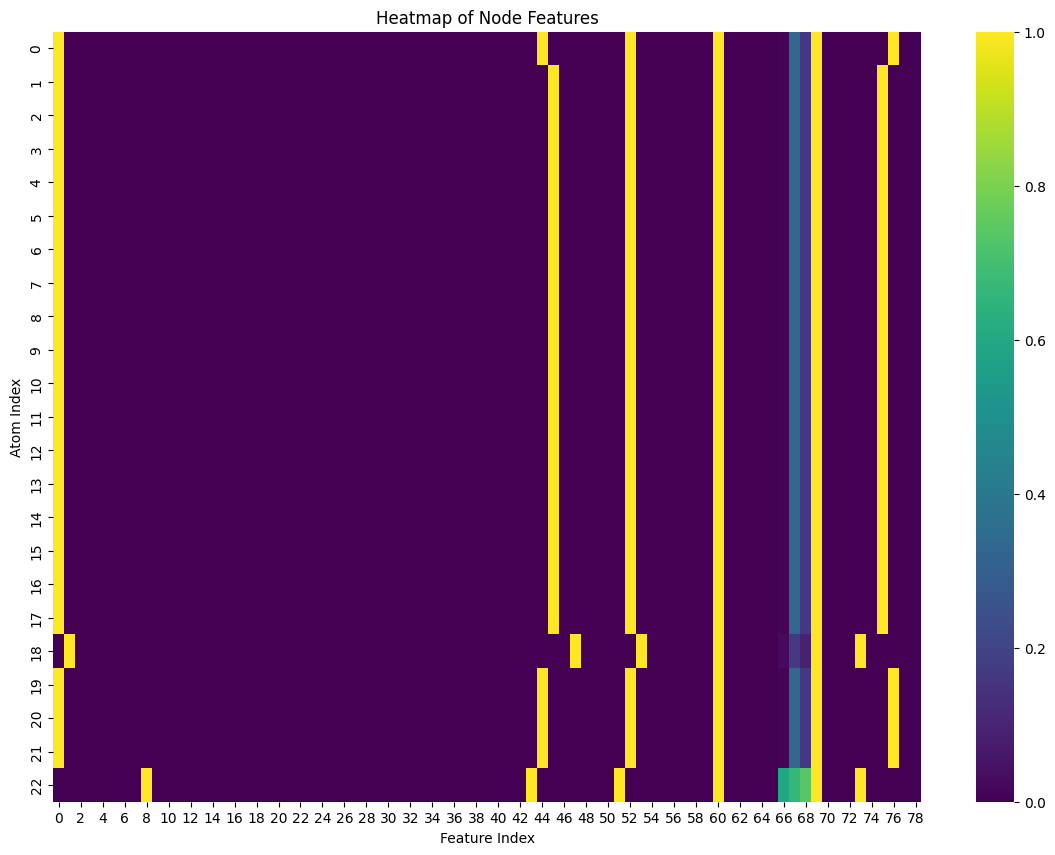

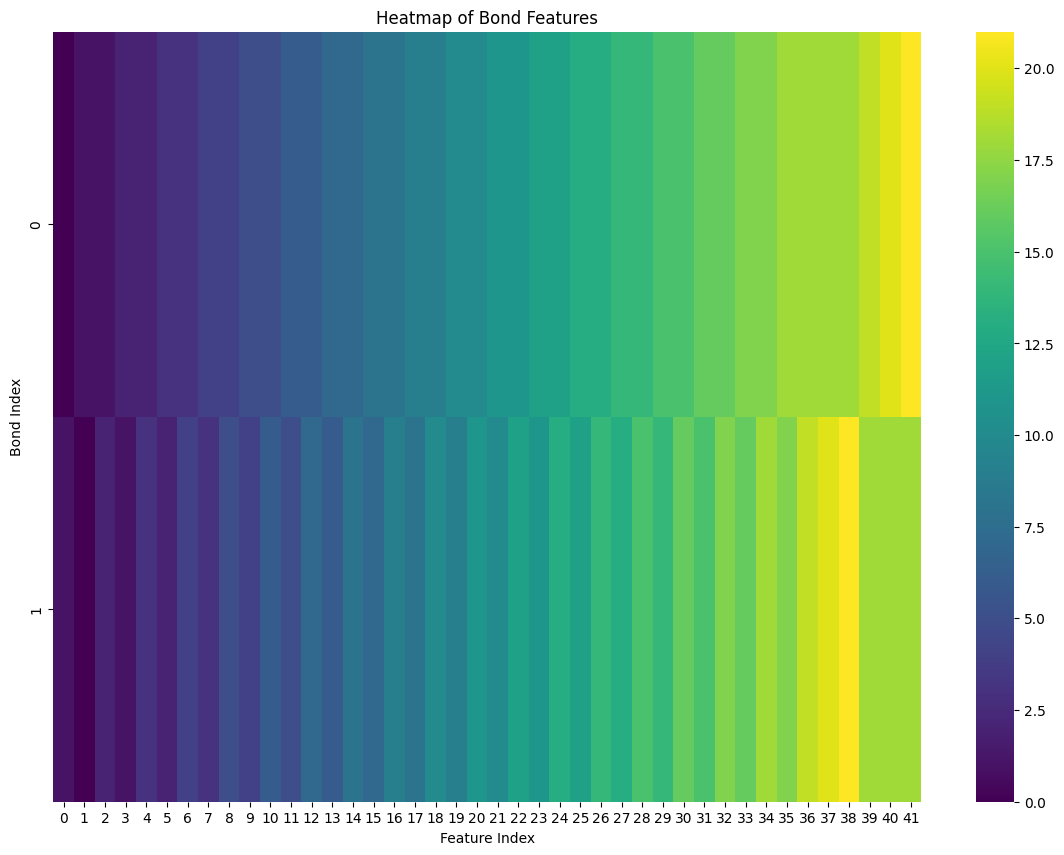

In [ ]:
data = graph_feature_vectors[0]

# Extract the node features
node_features = data.x.numpy()
edge_attributes = data.edge_index.numpy()

# Plotting the node features heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(node_features, annot=False, cmap='viridis')
plt.title('Heatmap of Node Features')
plt.xlabel('Feature Index')
plt.ylabel('Atom Index')
plt.show()

# Plotting the edge attributes heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(edge_attributes, annot=False, cmap='viridis')
plt.title('Heatmap of Bond Features')
plt.xlabel('Feature Index')
plt.ylabel('Bond Index')
plt.show()

In [ ]:
train_data, test_data = train_test_split(graph_feature_vectors, test_size=0.3, random_state=42)
print("Number of training samples:", len(train_data))
print("Number of test samples:", len(test_data))

Number of training samples: 6987
Number of test samples: 2995


In [ ]:
class GCN(torch.nn.Module):
    def __init__(self, num_features, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(42)

        # Initialize GCN layers
        self.conv1 = GCNConv(num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels , hidden_channels)
        self.conv4 = GCNConv(hidden_channels, hidden_channels)

        #Adding Batch Normalization
        self.bn1 = BatchNorm(hidden_channels)
        self.bn2 = BatchNorm(hidden_channels)
        self.bn3 = BatchNorm(hidden_channels)
        self.bn4 = BatchNorm(hidden_channels)



        # Linear layer for output
        self.out = Linear(2*hidden_channels, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Apply GCN layers with BatchNorm, ReLU activation, and Dropout
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=0.3, training=self.training)

        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = F.dropout(x, p=0.3, training=self.training)

        x = F.relu(self.bn3(self.conv3(x, edge_index)))
        x = F.dropout(x, p=0.3, training=self.training)

        x = F.relu(self.bn4(self.conv4(x, edge_index)))
        x = F.dropout(x, p=0.3, training=self.training)

        # Global pooling
        x_pool1 = gmp(x, data.batch)  # Global max pooling
        x_pool2 = gap(x, data.batch)  # Global average pooling

        # Concatenate the global pooling features
        hidden_representations = torch.cat([x_pool1, x_pool2], dim=1)

        # Output layer
        res = self.out(hidden_representations)

        return res



device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_features = graph_feature_vectors[0].num_node_features
model = GCN(num_features=num_features, hidden_channels=128).to(device)

print(model)

GCN(
  (conv1): GCNConv(79, 128)
  (conv2): GCNConv(128, 128)
  (conv3): GCNConv(128, 128)
  (conv4): GCNConv(128, 128)
  (bn1): BatchNorm(128)
  (bn2): BatchNorm(128)
  (bn3): BatchNorm(128)
  (bn4): BatchNorm(128)
  (out): Linear(in_features=256, out_features=1, bias=True)
)


In [ ]:
import warnings
warnings.filterwarnings("ignore")

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=0.1)
criterion = torch.nn.MSELoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=30)



model.train()
losses = []

for epoch in range(200):  # Train for 100 epochs
    model.train()
    running_loss = 0.0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        out = out.view(-1)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{200}, Loss: {epoch_loss:.4f}")


Epoch 1: 100%|██████████| 110/110 [00:02<00:00, 42.10it/s]


Epoch 1/200, Loss: 15.5065


Epoch 2: 100%|██████████| 110/110 [00:01<00:00, 89.59it/s]


Epoch 2/200, Loss: 3.6508


Epoch 3: 100%|██████████| 110/110 [00:01<00:00, 91.97it/s]


Epoch 3/200, Loss: 3.1600


Epoch 4: 100%|██████████| 110/110 [00:01<00:00, 88.14it/s]


Epoch 4/200, Loss: 2.9007


Epoch 5: 100%|██████████| 110/110 [00:01<00:00, 88.87it/s]


Epoch 5/200, Loss: 2.6608


Epoch 6: 100%|██████████| 110/110 [00:01<00:00, 92.21it/s]


Epoch 6/200, Loss: 2.4399


Epoch 7: 100%|██████████| 110/110 [00:01<00:00, 91.50it/s]


Epoch 7/200, Loss: 2.3191


Epoch 8: 100%|██████████| 110/110 [00:01<00:00, 91.99it/s]


Epoch 8/200, Loss: 2.3326


Epoch 9: 100%|██████████| 110/110 [00:01<00:00, 93.25it/s]


Epoch 9/200, Loss: 2.2304


Epoch 10: 100%|██████████| 110/110 [00:01<00:00, 94.60it/s]


Epoch 10/200, Loss: 2.1123


Epoch 11: 100%|██████████| 110/110 [00:01<00:00, 93.38it/s]


Epoch 11/200, Loss: 2.1408


Epoch 12: 100%|██████████| 110/110 [00:01<00:00, 92.85it/s]


Epoch 12/200, Loss: 2.1798


Epoch 13: 100%|██████████| 110/110 [00:01<00:00, 93.48it/s]


Epoch 13/200, Loss: 2.1658


Epoch 14: 100%|██████████| 110/110 [00:01<00:00, 93.55it/s]


Epoch 14/200, Loss: 2.0503


Epoch 15: 100%|██████████| 110/110 [00:01<00:00, 89.91it/s]


Epoch 15/200, Loss: 1.9672


Epoch 16: 100%|██████████| 110/110 [00:01<00:00, 93.74it/s]


Epoch 16/200, Loss: 2.2474


Epoch 17: 100%|██████████| 110/110 [00:01<00:00, 91.10it/s]


Epoch 17/200, Loss: 2.1794


Epoch 18: 100%|██████████| 110/110 [00:01<00:00, 92.71it/s]


Epoch 18/200, Loss: 2.0233


Epoch 19: 100%|██████████| 110/110 [00:01<00:00, 92.17it/s]


Epoch 19/200, Loss: 2.0722


Epoch 20: 100%|██████████| 110/110 [00:01<00:00, 94.60it/s]


Epoch 20/200, Loss: 2.0492


Epoch 21: 100%|██████████| 110/110 [00:01<00:00, 93.54it/s]


Epoch 21/200, Loss: 2.0098


Epoch 22: 100%|██████████| 110/110 [00:01<00:00, 93.95it/s]


Epoch 22/200, Loss: 2.0722


Epoch 23: 100%|██████████| 110/110 [00:01<00:00, 92.94it/s]


Epoch 23/200, Loss: 1.9570


Epoch 24: 100%|██████████| 110/110 [00:01<00:00, 92.76it/s]


Epoch 24/200, Loss: 1.9165


Epoch 25: 100%|██████████| 110/110 [00:01<00:00, 92.76it/s]


Epoch 25/200, Loss: 1.9874


Epoch 26: 100%|██████████| 110/110 [00:01<00:00, 93.79it/s]


Epoch 26/200, Loss: 2.0900


Epoch 27: 100%|██████████| 110/110 [00:01<00:00, 93.86it/s]


Epoch 27/200, Loss: 2.0430


Epoch 28: 100%|██████████| 110/110 [00:01<00:00, 92.63it/s]


Epoch 28/200, Loss: 2.0201


Epoch 29: 100%|██████████| 110/110 [00:01<00:00, 93.13it/s]


Epoch 29/200, Loss: 2.0202


Epoch 30: 100%|██████████| 110/110 [00:01<00:00, 94.00it/s]


Epoch 30/200, Loss: 2.0052


Epoch 31: 100%|██████████| 110/110 [00:01<00:00, 94.97it/s]


Epoch 31/200, Loss: 1.9865


Epoch 32: 100%|██████████| 110/110 [00:01<00:00, 93.55it/s]


Epoch 32/200, Loss: 1.8682


Epoch 33: 100%|██████████| 110/110 [00:01<00:00, 94.13it/s]


Epoch 33/200, Loss: 1.9717


Epoch 34: 100%|██████████| 110/110 [00:01<00:00, 91.49it/s]


Epoch 34/200, Loss: 1.9796


Epoch 35: 100%|██████████| 110/110 [00:01<00:00, 91.18it/s]


Epoch 35/200, Loss: 1.8890


Epoch 36: 100%|██████████| 110/110 [00:01<00:00, 89.68it/s]


Epoch 36/200, Loss: 2.0283


Epoch 37: 100%|██████████| 110/110 [00:01<00:00, 93.61it/s]


Epoch 37/200, Loss: 1.9051


Epoch 38: 100%|██████████| 110/110 [00:01<00:00, 90.81it/s]


Epoch 38/200, Loss: 1.9457


Epoch 39: 100%|██████████| 110/110 [00:01<00:00, 93.15it/s]


Epoch 39/200, Loss: 2.0652


Epoch 40: 100%|██████████| 110/110 [00:01<00:00, 94.64it/s]


Epoch 40/200, Loss: 2.0713


Epoch 41: 100%|██████████| 110/110 [00:01<00:00, 91.96it/s]


Epoch 41/200, Loss: 2.0129


Epoch 42: 100%|██████████| 110/110 [00:01<00:00, 94.34it/s]


Epoch 42/200, Loss: 2.0722


Epoch 43: 100%|██████████| 110/110 [00:01<00:00, 93.39it/s]


Epoch 43/200, Loss: 1.9766


Epoch 44: 100%|██████████| 110/110 [00:01<00:00, 93.06it/s]


Epoch 44/200, Loss: 1.9975


Epoch 45: 100%|██████████| 110/110 [00:01<00:00, 92.64it/s]


Epoch 45/200, Loss: 1.9740


Epoch 46: 100%|██████████| 110/110 [00:01<00:00, 93.76it/s]


Epoch 46/200, Loss: 1.8338


Epoch 47: 100%|██████████| 110/110 [00:01<00:00, 93.80it/s]


Epoch 47/200, Loss: 1.9214


Epoch 48: 100%|██████████| 110/110 [00:01<00:00, 93.82it/s]


Epoch 48/200, Loss: 1.9731


Epoch 49: 100%|██████████| 110/110 [00:01<00:00, 93.90it/s]


Epoch 49/200, Loss: 1.8280


Epoch 50: 100%|██████████| 110/110 [00:01<00:00, 95.42it/s]


Epoch 50/200, Loss: 1.9080


Epoch 51: 100%|██████████| 110/110 [00:01<00:00, 95.00it/s]


Epoch 51/200, Loss: 1.8991


Epoch 52: 100%|██████████| 110/110 [00:01<00:00, 92.34it/s]


Epoch 52/200, Loss: 1.8501


Epoch 53: 100%|██████████| 110/110 [00:01<00:00, 92.60it/s]


Epoch 53/200, Loss: 1.8733


Epoch 54: 100%|██████████| 110/110 [00:01<00:00, 93.13it/s]


Epoch 54/200, Loss: 1.7761


Epoch 55: 100%|██████████| 110/110 [00:01<00:00, 93.84it/s]


Epoch 55/200, Loss: 1.8466


Epoch 56: 100%|██████████| 110/110 [00:01<00:00, 93.24it/s]


Epoch 56/200, Loss: 2.0049


Epoch 57: 100%|██████████| 110/110 [00:01<00:00, 95.58it/s]


Epoch 57/200, Loss: 1.8048


Epoch 58: 100%|██████████| 110/110 [00:01<00:00, 93.65it/s]


Epoch 58/200, Loss: 1.9244


Epoch 59: 100%|██████████| 110/110 [00:01<00:00, 92.16it/s]


Epoch 59/200, Loss: 1.9092


Epoch 60: 100%|██████████| 110/110 [00:01<00:00, 92.58it/s]


Epoch 60/200, Loss: 1.8273


Epoch 61: 100%|██████████| 110/110 [00:01<00:00, 93.67it/s]


Epoch 61/200, Loss: 1.8535


Epoch 62: 100%|██████████| 110/110 [00:01<00:00, 92.41it/s]


Epoch 62/200, Loss: 1.7531


Epoch 63: 100%|██████████| 110/110 [00:01<00:00, 92.80it/s]


Epoch 63/200, Loss: 1.7623


Epoch 64: 100%|██████████| 110/110 [00:01<00:00, 90.86it/s]


Epoch 64/200, Loss: 1.8120


Epoch 65: 100%|██████████| 110/110 [00:01<00:00, 92.11it/s]


Epoch 65/200, Loss: 1.7841


Epoch 66: 100%|██████████| 110/110 [00:01<00:00, 93.26it/s]


Epoch 66/200, Loss: 1.9152


Epoch 67: 100%|██████████| 110/110 [00:01<00:00, 93.26it/s]


Epoch 67/200, Loss: 1.8178


Epoch 68: 100%|██████████| 110/110 [00:01<00:00, 94.36it/s]


Epoch 68/200, Loss: 1.7697


Epoch 69: 100%|██████████| 110/110 [00:01<00:00, 94.77it/s]


Epoch 69/200, Loss: 1.8148


Epoch 70: 100%|██████████| 110/110 [00:01<00:00, 92.76it/s]


Epoch 70/200, Loss: 1.9703


Epoch 71: 100%|██████████| 110/110 [00:01<00:00, 91.26it/s]


Epoch 71/200, Loss: 1.7633


Epoch 72: 100%|██████████| 110/110 [00:01<00:00, 93.64it/s]


Epoch 72/200, Loss: 1.8625


Epoch 73: 100%|██████████| 110/110 [00:01<00:00, 92.36it/s]


Epoch 73/200, Loss: 1.9152


Epoch 74: 100%|██████████| 110/110 [00:01<00:00, 93.06it/s]


Epoch 74/200, Loss: 1.6909


Epoch 75: 100%|██████████| 110/110 [00:01<00:00, 93.29it/s]


Epoch 75/200, Loss: 1.8146


Epoch 76: 100%|██████████| 110/110 [00:01<00:00, 92.62it/s]


Epoch 76/200, Loss: 1.6702


Epoch 77: 100%|██████████| 110/110 [00:01<00:00, 93.24it/s]


Epoch 77/200, Loss: 1.7539


Epoch 78: 100%|██████████| 110/110 [00:01<00:00, 93.42it/s]


Epoch 78/200, Loss: 1.7744


Epoch 79: 100%|██████████| 110/110 [00:01<00:00, 93.76it/s]


Epoch 79/200, Loss: 1.9178


Epoch 80: 100%|██████████| 110/110 [00:01<00:00, 94.29it/s]


Epoch 80/200, Loss: 1.6493


Epoch 81: 100%|██████████| 110/110 [00:01<00:00, 92.36it/s]


Epoch 81/200, Loss: 1.8074


Epoch 82: 100%|██████████| 110/110 [00:01<00:00, 92.28it/s]


Epoch 82/200, Loss: 1.7385


Epoch 83: 100%|██████████| 110/110 [00:01<00:00, 92.84it/s]


Epoch 83/200, Loss: 1.6789


Epoch 84: 100%|██████████| 110/110 [00:01<00:00, 94.01it/s]


Epoch 84/200, Loss: 1.8340


Epoch 85: 100%|██████████| 110/110 [00:01<00:00, 94.88it/s]


Epoch 85/200, Loss: 1.7257


Epoch 86: 100%|██████████| 110/110 [00:01<00:00, 94.68it/s]


Epoch 86/200, Loss: 1.7605


Epoch 87: 100%|██████████| 110/110 [00:01<00:00, 92.81it/s]


Epoch 87/200, Loss: 1.8296


Epoch 88: 100%|██████████| 110/110 [00:01<00:00, 93.85it/s]


Epoch 88/200, Loss: 1.7769


Epoch 89: 100%|██████████| 110/110 [00:01<00:00, 94.19it/s]


Epoch 89/200, Loss: 1.7450


Epoch 90: 100%|██████████| 110/110 [00:01<00:00, 93.99it/s]


Epoch 90/200, Loss: 1.7447


Epoch 91: 100%|██████████| 110/110 [00:01<00:00, 93.90it/s]


Epoch 91/200, Loss: 1.6961


Epoch 92: 100%|██████████| 110/110 [00:01<00:00, 90.66it/s]


Epoch 92/200, Loss: 1.7572


Epoch 93: 100%|██████████| 110/110 [00:01<00:00, 93.37it/s]


Epoch 93/200, Loss: 1.7604


Epoch 94: 100%|██████████| 110/110 [00:01<00:00, 93.88it/s]


Epoch 94/200, Loss: 1.6437


Epoch 95: 100%|██████████| 110/110 [00:01<00:00, 92.59it/s]


Epoch 95/200, Loss: 1.6807


Epoch 96: 100%|██████████| 110/110 [00:01<00:00, 94.52it/s]


Epoch 96/200, Loss: 1.6650


Epoch 97: 100%|██████████| 110/110 [00:01<00:00, 93.65it/s]


Epoch 97/200, Loss: 1.9037


Epoch 98: 100%|██████████| 110/110 [00:01<00:00, 89.13it/s]


Epoch 98/200, Loss: 1.8117


Epoch 99: 100%|██████████| 110/110 [00:01<00:00, 94.63it/s]


Epoch 99/200, Loss: 1.8085


Epoch 100: 100%|██████████| 110/110 [00:01<00:00, 92.86it/s]


Epoch 100/200, Loss: 1.6910


Epoch 101: 100%|██████████| 110/110 [00:01<00:00, 92.86it/s]


Epoch 101/200, Loss: 1.7418


Epoch 102: 100%|██████████| 110/110 [00:01<00:00, 93.25it/s]


Epoch 102/200, Loss: 1.9388


Epoch 103: 100%|██████████| 110/110 [00:01<00:00, 93.03it/s]


Epoch 103/200, Loss: 1.7443


Epoch 104: 100%|██████████| 110/110 [00:01<00:00, 93.14it/s]


Epoch 104/200, Loss: 1.7244


Epoch 105: 100%|██████████| 110/110 [00:01<00:00, 94.76it/s]


Epoch 105/200, Loss: 1.7448


Epoch 106: 100%|██████████| 110/110 [00:01<00:00, 93.24it/s]


Epoch 106/200, Loss: 1.7141


Epoch 107: 100%|██████████| 110/110 [00:01<00:00, 94.09it/s]


Epoch 107/200, Loss: 1.7406


Epoch 108: 100%|██████████| 110/110 [00:01<00:00, 93.55it/s]


Epoch 108/200, Loss: 1.6371


Epoch 109: 100%|██████████| 110/110 [00:01<00:00, 91.17it/s]


Epoch 109/200, Loss: 1.7893


Epoch 110: 100%|██████████| 110/110 [00:01<00:00, 92.40it/s]


Epoch 110/200, Loss: 1.7339


Epoch 111: 100%|██████████| 110/110 [00:01<00:00, 93.32it/s]


Epoch 111/200, Loss: 1.8181


Epoch 112: 100%|██████████| 110/110 [00:01<00:00, 92.47it/s]


Epoch 112/200, Loss: 1.6628


Epoch 113: 100%|██████████| 110/110 [00:01<00:00, 92.55it/s]


Epoch 113/200, Loss: 1.7336


Epoch 114: 100%|██████████| 110/110 [00:01<00:00, 94.67it/s]


Epoch 114/200, Loss: 1.5966


Epoch 115: 100%|██████████| 110/110 [00:01<00:00, 93.89it/s]


Epoch 115/200, Loss: 1.6778


Epoch 116: 100%|██████████| 110/110 [00:01<00:00, 94.53it/s]


Epoch 116/200, Loss: 1.6850


Epoch 117: 100%|██████████| 110/110 [00:01<00:00, 95.00it/s]


Epoch 117/200, Loss: 1.6465


Epoch 118: 100%|██████████| 110/110 [00:01<00:00, 93.48it/s]


Epoch 118/200, Loss: 1.6277


Epoch 119: 100%|██████████| 110/110 [00:01<00:00, 93.24it/s]


Epoch 119/200, Loss: 1.6386


Epoch 120: 100%|██████████| 110/110 [00:01<00:00, 93.28it/s]


Epoch 120/200, Loss: 1.5999


Epoch 121: 100%|██████████| 110/110 [00:01<00:00, 91.88it/s]


Epoch 121/200, Loss: 1.6866


Epoch 122: 100%|██████████| 110/110 [00:01<00:00, 92.17it/s]


Epoch 122/200, Loss: 1.6921


Epoch 123: 100%|██████████| 110/110 [00:01<00:00, 92.55it/s]


Epoch 123/200, Loss: 1.6521


Epoch 124: 100%|██████████| 110/110 [00:01<00:00, 93.56it/s]


Epoch 124/200, Loss: 1.6031


Epoch 125: 100%|██████████| 110/110 [00:01<00:00, 93.27it/s]


Epoch 125/200, Loss: 1.8428


Epoch 126: 100%|██████████| 110/110 [00:01<00:00, 93.86it/s]


Epoch 126/200, Loss: 1.6117


Epoch 127: 100%|██████████| 110/110 [00:01<00:00, 91.97it/s]


Epoch 127/200, Loss: 1.6372


Epoch 128: 100%|██████████| 110/110 [00:01<00:00, 93.50it/s]


Epoch 128/200, Loss: 1.7367


Epoch 129: 100%|██████████| 110/110 [00:01<00:00, 94.05it/s]


Epoch 129/200, Loss: 1.6013


Epoch 130: 100%|██████████| 110/110 [00:01<00:00, 88.87it/s]


Epoch 130/200, Loss: 1.6475


Epoch 131: 100%|██████████| 110/110 [00:01<00:00, 93.81it/s]


Epoch 131/200, Loss: 1.5848


Epoch 132: 100%|██████████| 110/110 [00:01<00:00, 92.85it/s]


Epoch 132/200, Loss: 1.7040


Epoch 133: 100%|██████████| 110/110 [00:01<00:00, 93.91it/s]


Epoch 133/200, Loss: 1.6468


Epoch 134: 100%|██████████| 110/110 [00:01<00:00, 93.13it/s]


Epoch 134/200, Loss: 1.5323


Epoch 135: 100%|██████████| 110/110 [00:01<00:00, 93.89it/s]


Epoch 135/200, Loss: 1.5929


Epoch 136: 100%|██████████| 110/110 [00:01<00:00, 93.32it/s]


Epoch 136/200, Loss: 1.6615


Epoch 137: 100%|██████████| 110/110 [00:01<00:00, 94.21it/s]


Epoch 137/200, Loss: 1.6947


Epoch 138: 100%|██████████| 110/110 [00:01<00:00, 92.72it/s]


Epoch 138/200, Loss: 1.6246


Epoch 139: 100%|██████████| 110/110 [00:01<00:00, 91.35it/s]


Epoch 139/200, Loss: 1.6390


Epoch 140: 100%|██████████| 110/110 [00:01<00:00, 89.92it/s]


Epoch 140/200, Loss: 1.7157


Epoch 141: 100%|██████████| 110/110 [00:01<00:00, 91.94it/s]


Epoch 141/200, Loss: 1.6145


Epoch 142: 100%|██████████| 110/110 [00:01<00:00, 93.40it/s]


Epoch 142/200, Loss: 1.6870


Epoch 143: 100%|██████████| 110/110 [00:01<00:00, 93.11it/s]


Epoch 143/200, Loss: 1.6545


Epoch 144: 100%|██████████| 110/110 [00:01<00:00, 92.51it/s]


Epoch 144/200, Loss: 1.6375


Epoch 145: 100%|██████████| 110/110 [00:01<00:00, 93.82it/s]


Epoch 145/200, Loss: 1.5220


Epoch 146: 100%|██████████| 110/110 [00:01<00:00, 92.29it/s]


Epoch 146/200, Loss: 1.5863


Epoch 147: 100%|██████████| 110/110 [00:01<00:00, 91.34it/s]


Epoch 147/200, Loss: 1.6098


Epoch 148: 100%|██████████| 110/110 [00:01<00:00, 92.05it/s]


Epoch 148/200, Loss: 1.4687


Epoch 149: 100%|██████████| 110/110 [00:01<00:00, 90.38it/s]


Epoch 149/200, Loss: 1.5558


Epoch 150: 100%|██████████| 110/110 [00:01<00:00, 91.05it/s]


Epoch 150/200, Loss: 1.4712


Epoch 151: 100%|██████████| 110/110 [00:01<00:00, 91.38it/s]


Epoch 151/200, Loss: 1.5162


Epoch 152: 100%|██████████| 110/110 [00:01<00:00, 90.31it/s]


Epoch 152/200, Loss: 1.7188


Epoch 153: 100%|██████████| 110/110 [00:01<00:00, 91.67it/s]


Epoch 153/200, Loss: 1.6056


Epoch 154: 100%|██████████| 110/110 [00:01<00:00, 91.89it/s]


Epoch 154/200, Loss: 1.7054


Epoch 155: 100%|██████████| 110/110 [00:01<00:00, 92.41it/s]


Epoch 155/200, Loss: 1.6198


Epoch 156: 100%|██████████| 110/110 [00:01<00:00, 93.73it/s]


Epoch 156/200, Loss: 1.7468


Epoch 157: 100%|██████████| 110/110 [00:01<00:00, 91.84it/s]


Epoch 157/200, Loss: 1.6437


Epoch 158: 100%|██████████| 110/110 [00:01<00:00, 90.91it/s]


Epoch 158/200, Loss: 1.7151


Epoch 159: 100%|██████████| 110/110 [00:01<00:00, 90.44it/s]


Epoch 159/200, Loss: 1.7182


Epoch 160: 100%|██████████| 110/110 [00:01<00:00, 91.77it/s]


Epoch 160/200, Loss: 1.6143


Epoch 161: 100%|██████████| 110/110 [00:01<00:00, 92.06it/s]


Epoch 161/200, Loss: 1.6317


Epoch 162: 100%|██████████| 110/110 [00:01<00:00, 92.94it/s]


Epoch 162/200, Loss: 1.5687


Epoch 163: 100%|██████████| 110/110 [00:01<00:00, 92.98it/s]


Epoch 163/200, Loss: 1.5640


Epoch 164: 100%|██████████| 110/110 [00:01<00:00, 94.75it/s]


Epoch 164/200, Loss: 1.5408


Epoch 165: 100%|██████████| 110/110 [00:01<00:00, 94.55it/s]


Epoch 165/200, Loss: 1.6464


Epoch 166: 100%|██████████| 110/110 [00:01<00:00, 95.66it/s]


Epoch 166/200, Loss: 1.4733


Epoch 167: 100%|██████████| 110/110 [00:01<00:00, 94.70it/s]


Epoch 167/200, Loss: 1.5588


Epoch 168: 100%|██████████| 110/110 [00:01<00:00, 92.94it/s]


Epoch 168/200, Loss: 1.5731


Epoch 169: 100%|██████████| 110/110 [00:01<00:00, 92.59it/s]


Epoch 169/200, Loss: 1.6547


Epoch 170: 100%|██████████| 110/110 [00:01<00:00, 92.35it/s]


Epoch 170/200, Loss: 1.7144


Epoch 171: 100%|██████████| 110/110 [00:01<00:00, 94.80it/s]


Epoch 171/200, Loss: 1.6119


Epoch 172: 100%|██████████| 110/110 [00:01<00:00, 94.30it/s]


Epoch 172/200, Loss: 1.5283


Epoch 173: 100%|██████████| 110/110 [00:01<00:00, 95.18it/s]


Epoch 173/200, Loss: 1.6644


Epoch 174: 100%|██████████| 110/110 [00:01<00:00, 94.25it/s]


Epoch 174/200, Loss: 1.5300


Epoch 175: 100%|██████████| 110/110 [00:01<00:00, 94.96it/s]


Epoch 175/200, Loss: 1.5010


Epoch 176: 100%|██████████| 110/110 [00:01<00:00, 94.67it/s]


Epoch 176/200, Loss: 1.5039


Epoch 177: 100%|██████████| 110/110 [00:01<00:00, 94.67it/s]


Epoch 177/200, Loss: 1.5622


Epoch 178: 100%|██████████| 110/110 [00:01<00:00, 93.43it/s]


Epoch 178/200, Loss: 1.5653


Epoch 179: 100%|██████████| 110/110 [00:01<00:00, 93.60it/s]


Epoch 179/200, Loss: 1.6092


Epoch 180: 100%|██████████| 110/110 [00:01<00:00, 94.36it/s]


Epoch 180/200, Loss: 1.5936


Epoch 181: 100%|██████████| 110/110 [00:01<00:00, 93.46it/s]


Epoch 181/200, Loss: 1.4937


Epoch 182: 100%|██████████| 110/110 [00:01<00:00, 94.24it/s]


Epoch 182/200, Loss: 1.6484


Epoch 183: 100%|██████████| 110/110 [00:01<00:00, 93.43it/s]


Epoch 183/200, Loss: 1.7222


Epoch 184: 100%|██████████| 110/110 [00:01<00:00, 93.62it/s]


Epoch 184/200, Loss: 1.5436


Epoch 185: 100%|██████████| 110/110 [00:01<00:00, 92.12it/s]


Epoch 185/200, Loss: 1.5318


Epoch 186: 100%|██████████| 110/110 [00:01<00:00, 94.07it/s]


Epoch 186/200, Loss: 1.6127


Epoch 187: 100%|██████████| 110/110 [00:01<00:00, 94.74it/s]


Epoch 187/200, Loss: 1.5047


Epoch 188: 100%|██████████| 110/110 [00:01<00:00, 92.80it/s]


Epoch 188/200, Loss: 1.5464


Epoch 189: 100%|██████████| 110/110 [00:01<00:00, 94.37it/s]


Epoch 189/200, Loss: 1.5020


Epoch 190: 100%|██████████| 110/110 [00:01<00:00, 94.48it/s]


Epoch 190/200, Loss: 1.5989


Epoch 191: 100%|██████████| 110/110 [00:01<00:00, 93.04it/s]


Epoch 191/200, Loss: 1.5587


Epoch 192: 100%|██████████| 110/110 [00:01<00:00, 94.07it/s]


Epoch 192/200, Loss: 1.4932


Epoch 193: 100%|██████████| 110/110 [00:01<00:00, 92.10it/s]


Epoch 193/200, Loss: 1.5575


Epoch 194: 100%|██████████| 110/110 [00:01<00:00, 92.49it/s]


Epoch 194/200, Loss: 1.5112


Epoch 195: 100%|██████████| 110/110 [00:01<00:00, 92.36it/s]


Epoch 195/200, Loss: 1.5106


Epoch 196: 100%|██████████| 110/110 [00:01<00:00, 91.61it/s]


Epoch 196/200, Loss: 1.5015


Epoch 197: 100%|██████████| 110/110 [00:01<00:00, 92.43it/s]


Epoch 197/200, Loss: 1.5773


Epoch 198: 100%|██████████| 110/110 [00:01<00:00, 92.09it/s]


Epoch 198/200, Loss: 1.5157


Epoch 199: 100%|██████████| 110/110 [00:01<00:00, 94.29it/s]


Epoch 199/200, Loss: 1.4463


Epoch 200: 100%|██████████| 110/110 [00:01<00:00, 94.48it/s]

Epoch 200/200, Loss: 1.5439


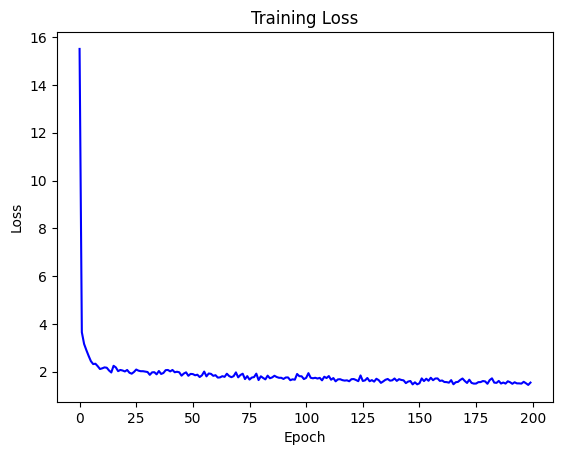

In [ ]:
losses_float = [float(loss) for loss in losses]
loss_indices = [i for i,l in enumerate(losses_float)]
plt.plot(loss_indices, losses_float, color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


In [ ]:
model.eval()
test_loss = 0.0
all_labels = []
all_predictions = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        outputs = model(batch)
        outputs = outputs.view(-1)  # Ensure output dimensions match the labels
        loss = criterion(outputs, batch.y)
        test_loss += loss.item()

        # Store outputs and labels for later metric calculations
        all_predictions.extend(outputs.cpu().numpy())
        all_labels.extend(batch.y.cpu().numpy())

# Calculate the average loss
average_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {average_test_loss:.4f}")

# Convert lists to NumPy arrays for metric calculations
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate MAE, MSE, RMSE
mae = mean_absolute_error(all_labels, all_predictions)
mse = mean_squared_error(all_labels, all_predictions)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error: {mae:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

Test Loss: 1.4611
Mean Absolute Error: 0.8659
Mean Squared Error: 1.4575
Root Mean Squared Error: 1.2073


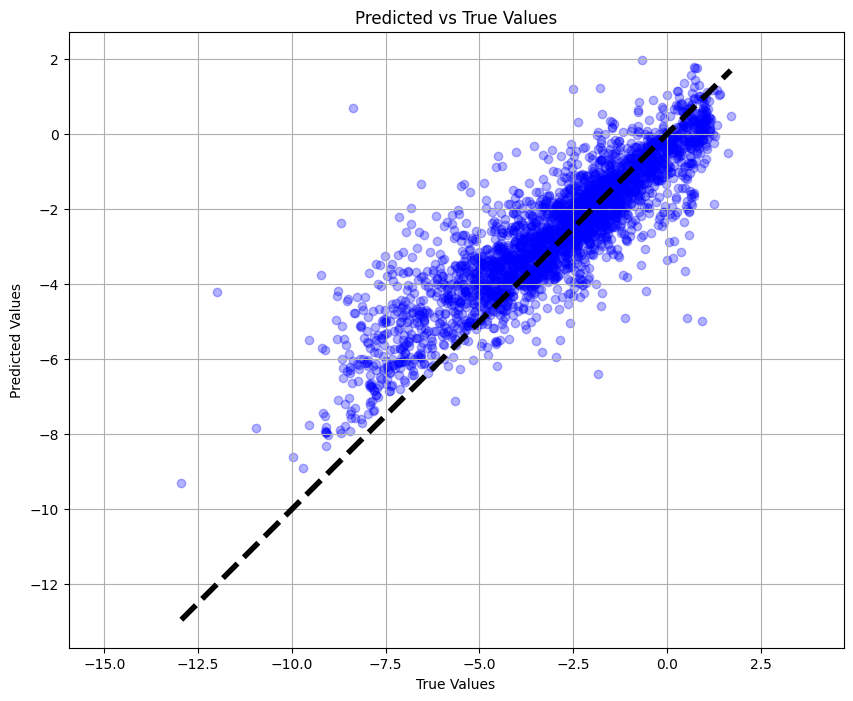

In [ ]:
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(all_labels, all_predictions, alpha=0.3, color='blue')  # Plot with some transparency
plt.title('Predicted vs True Values')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# Plot a line y = x for reference
plt.plot([all_labels.min(), all_labels.max()], [all_labels.min(), all_labels.max()], 'k--', lw=4)
plt.axis('equal')
plt.grid(True)

# Show the plot
plt.show()

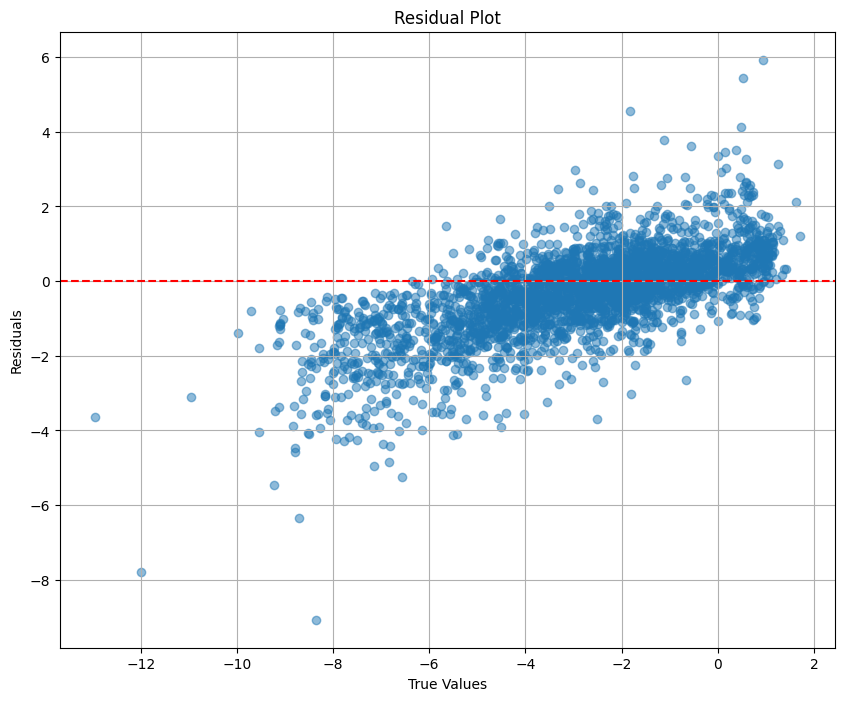

In [ ]:
# Calculate residuals
residuals = all_labels - all_predictions

plt.figure(figsize=(10, 8))
plt.scatter(all_labels, residuals, alpha=0.5)
plt.title('Residual Plot')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.grid(True)
plt.show()
